In [21]:
import numpy as np
from numpy import pi, sqrt, exp
import matplotlib.pyplot as plt

from scipy.special import factorial2, comb
from scipy.interpolate import splrep, splev, interp1d
from scipy.stats import norm

from numpy.polynomial.hermite import hermgauss

from py_vollib.black_scholes.implied_volatility import implied_volatility

# Imp vol estimator based on P. Jäckel's "Let's be rational"
vec_find_vol_rat = np.vectorize(implied_volatility)
import scipy.special
from scipy.stats import norm

np.random.seed(400)


In [22]:
def horner_vector(poly, x):
    result = poly[0] * np.ones_like(x)
    for coeff in poly[1:]:
        result = result * x + coeff
    return result

def make_fv_curve_interpolator(T_array, fv_array):
    from scipy.interpolate import interp1d
    return interp1d(T_array, fv_array, kind='cubic', fill_value='extrapolate')

def vec_find_vol_rat(prices, S0, strikes, T, flag, r=0.0):
    def safe_iv(price, K):
        try:
            return implied_volatility(price, S0, K, T, r, flag)
        except Exception as e:
            print(f"IV error for price={price:.4f}, K={K:.2f}: {e}")
            return np.nan
    return np.vectorize(safe_iv)(prices, strikes)

def bs_price_call(S, sigma, T, K):
    S = np.asarray(S)
    sigma = np.asarray(sigma)
    K = np.asarray(K)
    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call = S * norm.cdf(d1) - K * norm.cdf(d2)
        call = np.nan_to_num(call)
    return call

def compute_expected_fx2_analytical(a_k, eps, H, t_grid):
    """
    Computes E[f^2(X_t)] analytically under Gaussian assumption with correct covariance term.
    """

    n = len(a_k)
    cauchy_product = np.convolve(a_k, a_k)
    theta = (0.5 - H) / eps
    sigma = eps ** (H - 0.5)
    var_X = (sigma**2) / (2 * theta) * (1 - np.exp(-2 * theta * t_grid))
    std_X = np.sqrt(var_X)

    p_even = np.arange(0, 2 * n, 2)  # even exponents
    coeffs = cauchy_product[p_even].reshape(-1, 1)
    std_powers = std_X ** p_even.reshape(-1, 1)
    moments = scipy.special.factorial2(p_even - 1).reshape(-1, 1)
    moments[p_even.reshape(-1, 1) == 0] = 1  # (0-1)!! = 1

    expected_fx2 = np.sum(coeffs * std_powers * moments, axis=0)
    expected_fx2 = np.maximum(expected_fx2, 1e-12)
    return expected_fx2


In [ ]:
class OneQuinticOU():
    def __init__(self, eps, H, T, n_steps, N_sims, S0, rho, a_k, Y_storage=None):
        self.eps = eps
        self.H = H
        self.T = T
        self.n_steps = n_steps
        self.N_sims = N_sims
        self.S0 = S0
        self.rho = rho
        self.a_k = a_k
        self.sigma_t = None
        if Y_storage is None:
            Y_storage = np.random.normal(0, 1, (N_sims, n_steps))
            Y_storage[:, 0] = 0
            self.Y_storage = Y_storage
        else:
            self.Y_storage = Y_storage
    def  simulate_OU_X(self,x0=0.0):
        """
        Simulates the exact OU process and plots empirical vs theoretical variance.
        """
        dt = self.T / self.n_steps
        a = (0.5 - self.H) / self.eps
        sigma = self.eps ** (self.H - 0.5)
        X = np.zeros((self.N_sims, self.n_steps))
        X[:, 0] = x0
        exp_at = np.exp(-a * dt)
        var_term = sigma ** 2 / (2 * a) * (1 - np.exp(-2 * a * dt))
        for k in range(1,self.n_steps):
            Z = self.Y_storage[:, k]  
            X[:, k] = exp_at * X[:, k-1] + np.sqrt(var_term) * Z
        self.X = X
        return self.Y_storage, self.X
    def sigma(self, ksi_0, x0=0):
        self.simulate_OU_X(x0=x0)
        t_grid = np.linspace(0, self.T, self.n_steps)
        poly_vals = horner_vector(self.a_k[::-1], self.X)
        f_X_squared = poly_vals ** 2
        ksi_vals = ksi_0(t_grid)
        expected_fx2_mc = np.mean(f_X_squared, axis=0) + 1e-10
        expected_fx2 = compute_expected_fx2_analytical(self.a_k, self.eps, self.H,t_grid=t_grid)
        print("this value must be equal to 1, ",  np.mean(expected_fx2/expected_fx2_mc))
        scaling = (ksi_vals / np.maximum(expected_fx2, 1e-12))[None, :]
        sigma_squared = scaling
        self.sigma_t = np.abs(poly_vals * np.sqrt(sigma_squared))
        #print("sigma mean is ",np.mean(self.sigma_t))
        return (self.sigma_t)
    
    def simulate_logS_batched(self):
        if self.sigma_t is None:
            raise ValueError("Sigma must be initialized first with sigma().")
        dt = self.T / self.n_steps
        log_S = np.zeros((self.N_sims, self.n_steps))
        log_S[:, 0] = np.log(self.S0)
        for i in range(1, self.n_steps):
            sigma_prev = self.sigma_t[:, i - 1]
            drift = -0.5 * (self.rho * sigma_prev) ** 2 * dt
            diffusion = self.rho * sigma_prev * np.sqrt(dt) * self.Y_storage[:, i - 1]
            log_S[:, i] = log_S[:, i - 1] + drift + diffusion
        self.log_S = log_S
        return log_S

    def price_call_conditional_mc(self, ksi_0, strikes, x0=0, compute=False):
        self.sigma(ksi_0, x0=x0)
        log_S = self.simulate_logS_batched()
        ST = np.exp(log_S[:, -1])
        int_var = np.sum(self.sigma_t[:, :-1] ** 2 * (self.T / self.n_steps), axis=1)
        Q = max(int_var) + 1e-10
        vol_residual_X = np.sqrt((1 - self.rho ** 2) * int_var / self.T)
        vol_residual_Y = abs(self.rho) * np.sqrt(Q - int_var)

        X = np.zeros((self.N_sims, len(strikes)))
        Y = np.zeros((self.N_sims, len(strikes)))
        for j, K in enumerate(strikes):
            X[:, j] = bs_price_call(ST, vol_residual_X, self.T, K)
            Y[:, j] = bs_price_call(ST, vol_residual_Y, self.T, K)

        if compute:
            prices = X
            print(f"[price_call_conditional_mc] ST mean: {np.mean(ST)}, std: {np.std(ST)}")
            print(f"[price_call_conditional_mc] int_var mean: {np.mean(int_var)}, std: {np.std(int_var)}")
            print(f"[price_call_conditional_mc] vol_residual_X mean: {np.mean(vol_residual_X)}, std: {np.std(vol_residual_X)}")
            print(f"[price_call_conditional_mc] vol_residual_Y mean: {np.mean(vol_residual_Y)}, std: {np.std(vol_residual_Y)}")
            print(f"[price_call_conditional_mc] Prices mean: {np.mean(prices, axis=0)}")
            print(f"[price_call_conditional_mc] Prices std: {np.std(prices, axis=0)}")
            return np.mean(prices, axis=0), np.std(prices, axis=0)

        eY = np.mean(Y, axis=0)
        var_Y = np.var(Y, axis=0)
        cov_X_Y = np.mean(X * Y, axis=0) - eY * np.mean(X, axis=0)
        c = cov_X_Y / var_Y
        prices = X + c * (eY - Y)

        return np.mean(prices, axis=0), np.std(prices, axis=0)

    def run_pipeline(self, ksi_0_func, flag='c', r=0.0, x0=0, strike_array=None):
        if strike_array is None:
            lm = np.linspace(-0.2, 0.03, 50)
            strike_array = self.S0 * np.exp(lm)
        mean_prices, std_prices = self.price_call_conditional_mc(ksi_0_func, strike_array, x0=x0)
        imp_vols = vec_find_vol_rat(mean_prices, self.S0, strike_array, self.T, flag=flag, r=0)
        intrinsic_values = np.maximum(self.S0 - strike_array, 0)
        valid = mean_prices > intrinsic_values + 1e-4

        return strike_array[valid], imp_vols[valid]


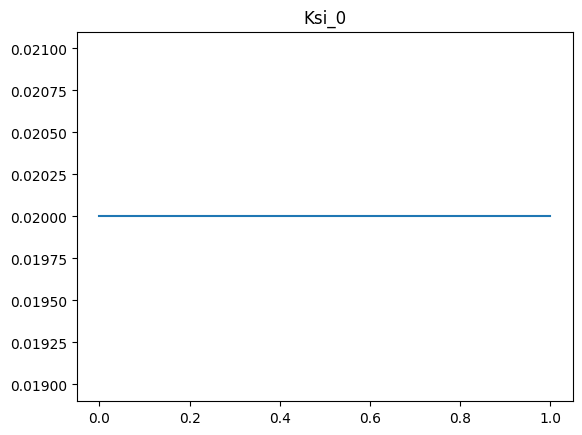

this value must be equal to 1,  0.9923698254973655
this value must be equal to 1,  0.9923698254973655


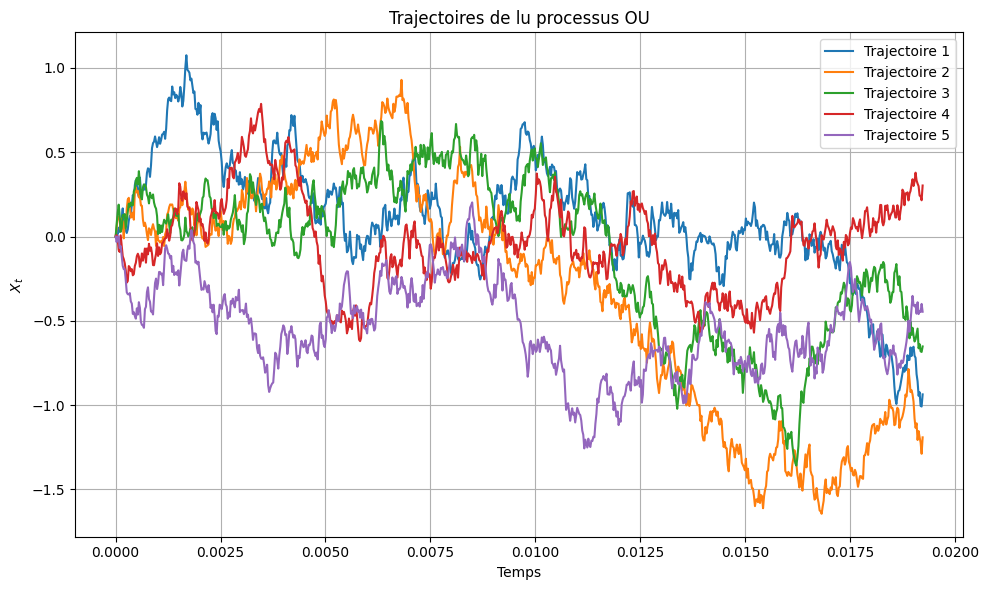

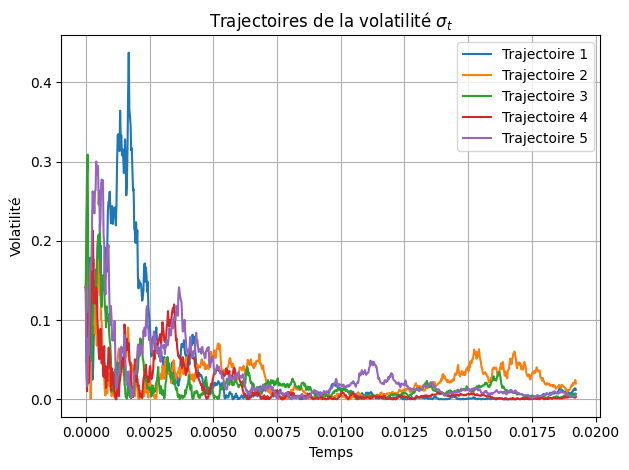

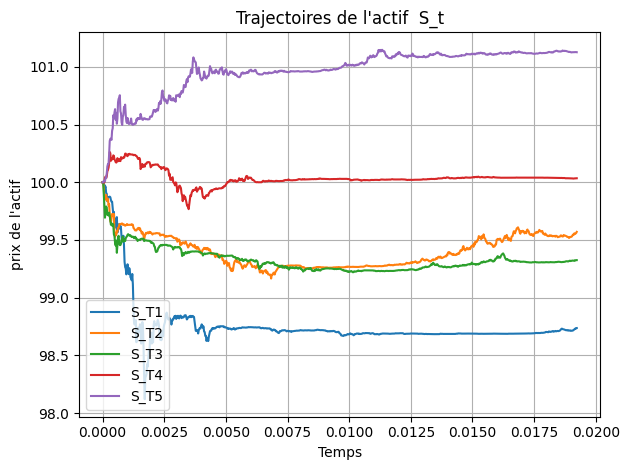

value final is  4.604930225514823
iv_smile is  [0.68428492 0.67195188 0.65962384 0.6473006  0.63498187 0.62266715
 0.61035575 0.59804678 0.58573906 0.57343116 0.56112135 0.54880757
 0.53648748 0.52415841 0.51181736 0.49946105 0.48708591 0.47468805
 0.46226335 0.44980739 0.43731548 0.42478267 0.41220371 0.39957307
 0.38688489 0.37413304 0.36131115 0.34841273 0.3354314  0.3223613
 0.30919774 0.29593828 0.2825842  0.26914281 0.2556305  0.2420775
 0.22853582 0.2150946  0.20191017 0.18926266 0.17767091 0.16811615
 0.16227315 0.16202214 0.16754858 0.1770301  0.18869398 0.20148271
 0.21480745 0.22834792]


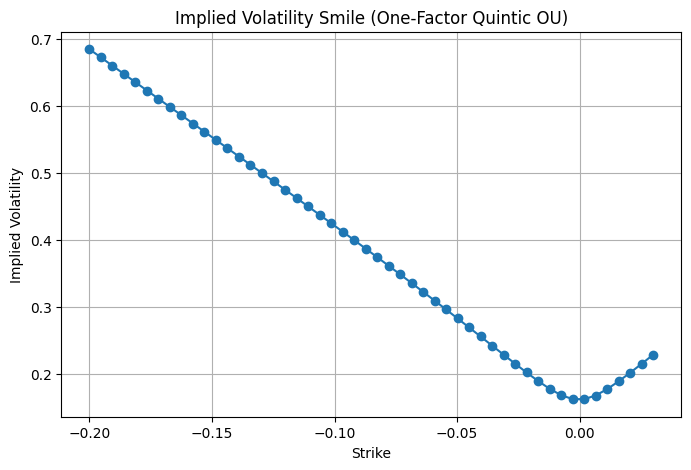

In [24]:
# ==== PARAMÈTRES ====
eps = 1 / 52
H = -0.1
a_k = [0.01,1,0,0.214,0, 0.227]
T = 1/52
n_steps = 800
N_sims = 40000
S0 = 100
rho = -0.65

# Courbe de variance à terme
T_array_nodes = np.array([0,0.03,1/12,2/12,3/12,6/12,12/12,24/12])

fv_nodes = np.ones_like(T_array_nodes)*(np.sqrt(0.02))
fv_func = make_fv_curve_interpolator(T_array_nodes, fv_nodes)
def ksi_0(t):
    return fv_func(t)**2
X0 = np.linspace(0,1,10)
Y0 = [ksi_0(x) for x in X0]
plt.plot(X0,Y0)
plt.title("Ksi_0")
plt.show()

# ==== SIMULATION ET SMILE ====np.mean(np.exp(model_base.log_S[:,-1]))
model = OneQuinticOU(eps, H, T, n_steps, N_sims, S0, rho, a_k,Y_storage=None)
sigma_1 = model.sigma(ksi_0=ksi_0)

#print("Max relative difference: ", np.max(np.abs(sigma_1 - sigma_2) / np.maximum(1e-12, np.abs(sigma_2))))
#print("Are they close? ", np.allclose(sigma_1, sigma_2, rtol=1e-10, atol=1e-12))

strikes, iv_smile = model.run_pipeline(ksi_0)
X0 = np.linspace(0, T, model.n_steps )  # temps correspondant aux pas de simulation

plt.figure(figsize=(10, 6))  # taille plus confortable pour visualisation
for i in range(5):
    X = model.X[i, :]
    plt.plot(X0, X, label=f'Trajectoire {i+1}')

plt.title("Trajectoires de lu processus OU")
plt.xlabel("Temps")
plt.ylabel("$X_t$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
for i in range(5):
    sigma = model.sigma_t[i, :]
    plt.plot(X0, sigma, label=f'Trajectoire {i+1}')

plt.title("Trajectoires de la volatilité $\sigma_t$")
plt.xlabel("Temps")
plt.ylabel("Volatilité")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
for i in range(5):
    S_T = np.exp(model.log_S[i,:])
    plt.plot(X0,S_T,label = f'S_T{i+1}')
plt.title("Trajectoires de l'actif  S_t")
plt.xlabel("Temps")
plt.ylabel("prix de l'actif")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
a = np.mean(model.log_S[:,-1])
print("value final is ",np.mean(model.log_S[:,-1]))

# ==== PLOT ====
plt.figure(figsize=(8, 5))
print("iv_smile is ",iv_smile)
plt.plot(np.log(strikes/S0), iv_smile, marker='o')
plt.title("Implied Volatility Smile (One-Factor Quintic OU)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()


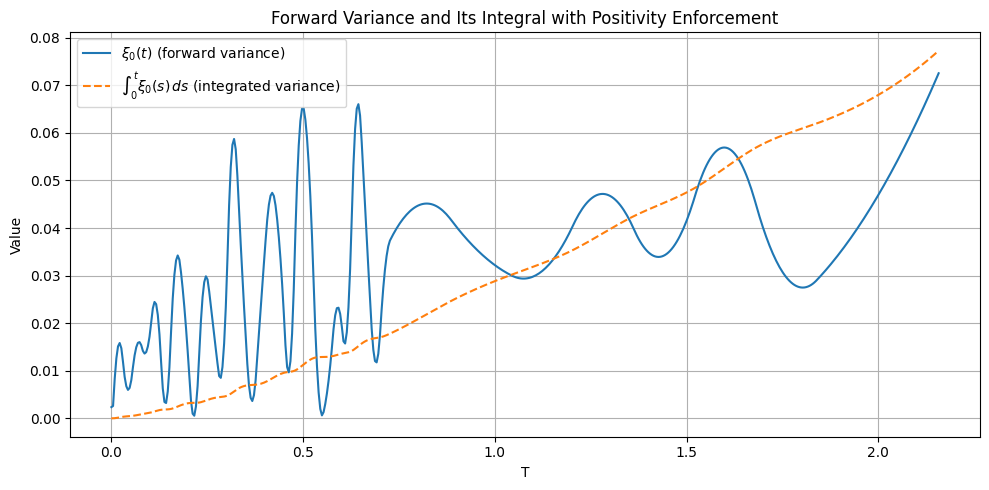

All values of ksi_0 positive? True
Min value of ksi_0: 0.0005527191774264942
ksi(0) = :0.002362937779691221


In [25]:
def compute_ssr(rho, eps, H, T, n_steps, N_sims, S0, a_k, ksi_0):
    ssr_h = 1e-4
    h_skew = 1e-4
    epsilon = 1e-4

    # ==== Antithetic Variates ====
    Y_storage = np.random.normal(0, 1, (N_sims, n_steps))
    Y_storage[:, 0] = 0  # Enforce W_0 = 0

    strike_array = S0 * np.exp([-h_skew, 0, h_skew])
    v0 = 0.001

    # ===== Skew estimation =====
    model_skew = OneQuinticOU(eps, H, T, n_steps, Y_storage.shape[0], S0, rho, a_k, Y_storage=Y_storage)
    strike_array, imp_vols = model_skew.run_pipeline(ksi_0, x0=0, strike_array=strike_array)
    skew = (imp_vols[2] - imp_vols[0]) / (2 * h_skew)

    # ===== Stickiness estimation =====
    incr = ssr_h * rho / (np.sqrt(v0))
    strike_atm = np.array([S0])
    model_base =  OneQuinticOU(eps, H, T, n_steps, Y_storage.shape[0], S0, rho, a_k, Y_storage=Y_storage)
    strike_array, imp_vols_0 = model_base.run_pipeline(ksi_0, x0=0, strike_array=strike_atm)
    model_incr = OneQuinticOU(eps, H, T, n_steps, Y_storage.shape[0], S0, rho, a_k, Y_storage=Y_storage)
    strike_array, imp_vols_incr = model_incr.run_pipeline(ksi_0, x0=incr, strike_array=strike_atm)
    d_sigma_dx = (imp_vols_incr - imp_vols_0) / ssr_h
    
    if np.abs(skew) < epsilon:
        ssr_value = np.nan
    else:
        ssr_value = (d_sigma_dx / skew)[0]
    return ssr_value, skew, d_sigma_dx[0]


# ==== PARAMÈTRES ====

# Forward variance stored in a dictionary - interpolated using cubic spline
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

# === Données ===
T_nodes = np.array([
    0.0001, 0.0005, 0.001 , 0.0015, 0.0055, 0.0303, 0.0552, 0.0801,
    0.105 , 0.1298, 0.1547, 0.1796, 0.2044, 0.2293, 0.2542, 0.2791,
    0.3039, 0.3288, 0.3537, 0.3785, 0.4034, 0.4283, 0.4531, 0.478 ,
    0.5029, 0.5278, 0.5526, 0.5775, 0.6024, 0.6272, 0.6521, 0.677 ,
    0.7019, 0.7267, 0.8857, 1.0447, 1.2036, 1.3626, 1.5216, 1.6805,
    1.8395, 1.9985, 2.1574
])

int_var_nodes = np.array([
    0.00000023, 0.00000117, 0.00000235, 0.00000352, 0.00001286,
    0.00033119, 0.00052188, 0.00088383, 0.00126912, 0.0017979 ,
    0.00196599, 0.00270324, 0.00322654, 0.00332477, 0.00396569,
    0.00442826, 0.0048271 , 0.00615094, 0.00692078, 0.00707639,
    0.0076925 , 0.00881826, 0.00963305, 0.01002174, 0.01142226,
    0.01267608, 0.012891  , 0.013082  , 0.01361588, 0.0141797 ,
    0.01568081, 0.01668033, 0.01704239, 0.01780291, 0.02466145,
    0.03022112, 0.03537132, 0.04249715, 0.04841705, 0.05687464,
    0.0619833 , 0.06789834, 0.07726454
])

#
# === Création de la spline cubique pour approximer la variance intégrée ===
spline_int_var = interpolate.splrep(T_nodes, int_var_nodes, k=3)

# === Fonction ksi_0 calculant la variance instantanée par dérivation avec positivité assurée ===
def ksi_0(t):
    deriv_values = interpolate.splev(t, spline_int_var, der=1)
    # Assure positivity:
    return np.sqrt(deriv_values ** 2)

# === Fonction pour calculer l'intégrale de ksi_0 ===
def integral_ksi_0(t):
    return interpolate.splev(t, spline_int_var, der=0)

# === Grille pour tracé ===
t_grid = np.linspace(T_nodes[0], T_nodes[-1], 500)
ksi_values = ksi_0(t_grid)
int_ksi_values = integral_ksi_0(t_grid)

# === Tracé ===
plt.figure(figsize=(10, 5))

plt.plot(t_grid, ksi_values, label=r'$\xi_0(t)$ (forward variance)')
plt.plot(t_grid, int_ksi_values, label=r'$\int_0^t \xi_0(s)\,ds$ (integrated variance)', linestyle='--')

plt.xlabel('T')
plt.ylabel('Value')
plt.title('Forward Variance and Its Integral with Positivity Enforcement')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Vérification positivité
print(f"All values of ksi_0 positive? {np.all(ksi_values >= 0)}")
print(f"Min value of ksi_0: {np.min(ksi_values)}")
print(f"ksi(0) = :{ksi_0(0)}")

this value must be equal to 1,  0.9810224611384517
this value must be equal to 1,  0.9810224611384517
this value must be equal to 1,  0.981057726971327
this value must be equal to 1,  1.0127715531313322
this value must be equal to 1,  1.0127715531313322
this value must be equal to 1,  1.012803772375934
this value must be equal to 1,  1.0449019778055482
this value must be equal to 1,  1.0449019778055482
this value must be equal to 1,  1.0449049444331013
this value must be equal to 1,  1.111669292710247
this value must be equal to 1,  1.111669292710247
this value must be equal to 1,  1.1116696853640768
this value must be equal to 1,  1.049725696192131
this value must be equal to 1,  1.049725696192131
this value must be equal to 1,  1.0497978067478613
this value must be equal to 1,  1.0445536679170402
this value must be equal to 1,  1.0445536679170402
this value must be equal to 1,  1.0445687169655968
this value must be equal to 1,  1.0141793448032224
this value must be equal to 1,  1.014

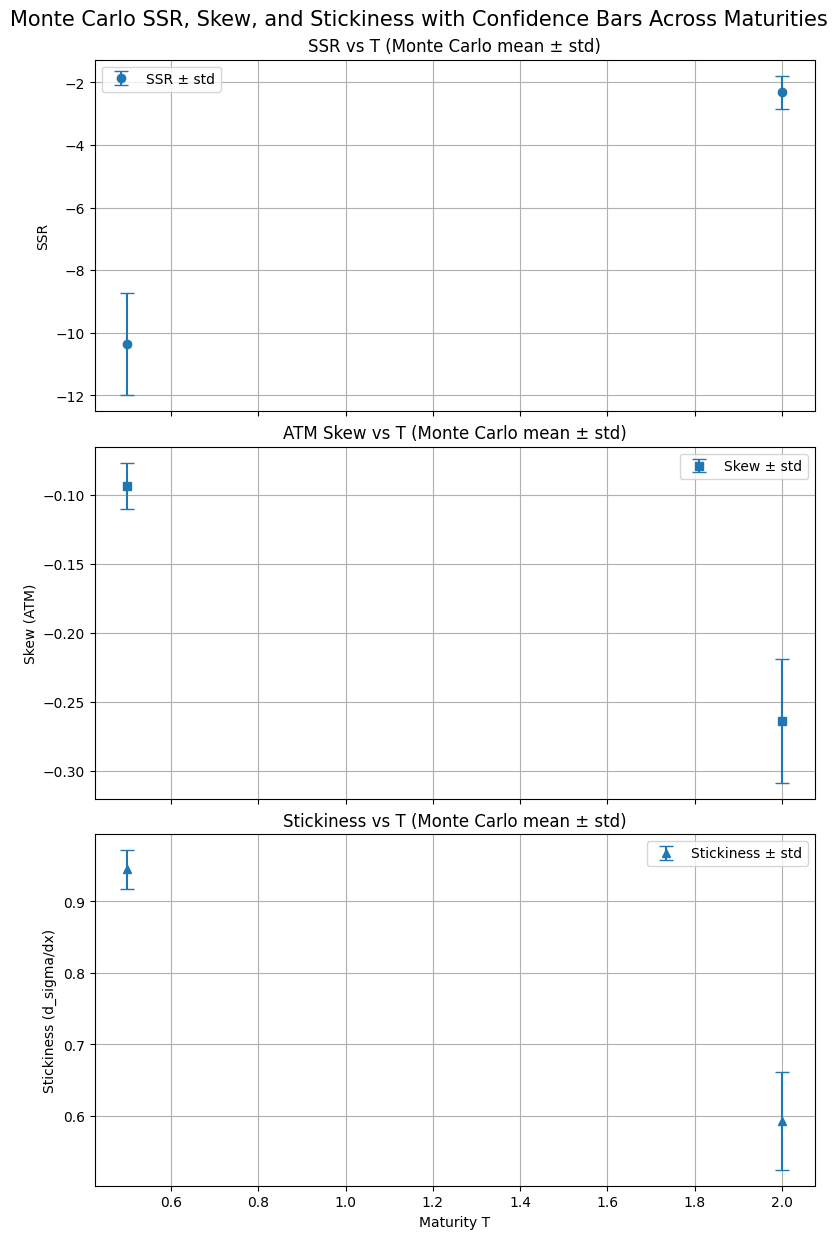

In [26]:
eps = 1 / 52
H = -0.1
a_k = np.array([0.04, 0.038, 0.04, 0.085, 0.05, 1])
T = 1/12
n_steps = 400
N_sims = 10000
S0 = 100
rho = -0.65

# === STORAGE for means and stds ===
Skew_means, Skew_stds = [], []
Stickiness_means, Stickiness_stds = [], []
SSR_means, SSR_stds = [], []

n_mc =  5 # Number of Monte Carlo repetitions per T
T_grid = np.linspace(0.5,2,2)
for T in T_grid:
    ssr_list = []
    skew_list = []
    stickiness_list = []
    for _ in range(n_mc):
        ssr_val, skew_val, stickiness_val = compute_ssr(
            rho=rho, eps=eps, H=H, T=T, n_steps=n_steps, 
            N_sims=N_sims, S0=S0, a_k=a_k, ksi_0=ksi_0
        )
        ssr_list.append(ssr_val)
        skew_list.append(skew_val)
        stickiness_list.append(stickiness_val)

    # Compute means
    SSR_means.append(np.nanmean(ssr_list))
    Skew_means.append(np.nanmean(skew_list))
    Stickiness_means.append(np.nanmean(stickiness_list))

    # Compute stds
    SSR_stds.append(np.nanstd(ssr_list))
    Skew_stds.append(np.nanstd(skew_list))
    Stickiness_stds.append(np.nanstd(stickiness_list))

# === PLOTTING ===

fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True, constrained_layout=True)

# SSR plot with std
axs[0].errorbar(T_grid, SSR_means, yerr=SSR_stds, fmt='o', capsize=5, label="SSR ± std")
axs[0].set_ylabel("SSR")
axs[0].set_title("SSR vs T (Monte Carlo mean ± std)")
axs[0].grid(True)
axs[0].legend()

# Skew plot with std
axs[1].errorbar(T_grid, Skew_means, yerr=Skew_stds, fmt='s', capsize=5, label="Skew ± std")
axs[1].set_ylabel("Skew (ATM)")
axs[1].set_title("ATM Skew vs T (Monte Carlo mean ± std)")
axs[1].grid(True)
axs[1].legend()

# Stickiness plot with std
axs[2].errorbar(T_grid, Stickiness_means, yerr=Stickiness_stds, fmt='^', capsize=5, label="Stickiness ± std")
axs[2].set_xlabel("Maturity T")
axs[2].set_ylabel("Stickiness (d_sigma/dx)")
axs[2].set_title("Stickiness vs T (Monte Carlo mean ± std)")
axs[2].grid(True)
axs[2].legend()

plt.suptitle("Monte Carlo SSR, Skew, and Stickiness with Confidence Bars Across Maturities", fontsize=15, y=1.02)
plt.show()


In [27]:
def vec_find_vol_rat(prices, S0, strikes, T, flag, r=0.0):
    def safe_iv(price, K):
        try:
            return implied_volatility(price, S0, K, T, r, flag)
        except Exception as e:
            print(f"IV error for price={price:.4f}, K={K:.2f}: {e}")
            return np.nan
    return np.vectorize(safe_iv)(prices, strikes)


In [28]:
data = np.loadtxt("/home/hassene/Desktop/Stage_code/one_dim_1001_5999/5999_1_nopti")
points = data[:-1, 1:2]
weights = data[:-1, 0]


In [29]:


def gauss_dens(mu, sigma, x):
    """Standard Gaussian density function."""
    return 1 / (sqrt(2 * pi) * sigma) * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def vec_find_vol_rat(prices, S0, strikes, T, r, flag):
    """Vectorized implied volatility computation with error handling."""
    def safe_iv(price, K):
        try:
            return implied_volatility(price, S0, K, T, r, flag)
        except Exception:
            return np.nan
    return np.vectorize(safe_iv)(prices, strikes)

class VIX_One_QUINTIC:
    def __init__(self, eps, H, n_steps, delta, a_k, T=1/12, ub_vix=8.0, lb_vix=-8.0):
        # Rough volatility model parameters
        self.eps = eps
        self.H = H
        self.n_steps = n_steps  # Discretization steps for integration
        self.delta = delta      # VIX averaging window (e.g. 30 days)
        self.a_k = np.array(a_k)  # Coefficients of polynomial f(x)
        self.T = T              # Current time (e.g. 1 month = 1/12)
        self.ub_vix = ub_vix    # Upper bound for integration
        self.lb_vix = lb_vix    # Lower bound for integration 
        self.beta = None        # Will hold β_i coefficients

    def compute_beta_vector_full(self, ksi_0):
        """
        Compute the constant coefficients β_i appearing in the quadratic-form
        representation of VIX² under the Quintic-OU rough-vol model.

        Mathematically we want
            VIX_T² = 1/Δ ∫_{T}^{T+Δ} f(X_t)² ξ₀(t) dt
                    = Σ_{i=0}^{2n-2} β_i X_T^i,           (1)

        where
          • f(x) = Σ_{k=0}^{n-1} a_k x^k   is our quintic (degree n-1) polynomial,
          • X_t  is the rough mean-reverting factor (OU-type),
          • ξ₀(t) is the *forward variance curve* passed as callable `ksi_0`,
          • Δ    = self.delta (30 days / 360 by default).

        The inner time integral is evaluated with the trapezoidal rule on a
        uniform grid of `n_steps + 1` points.  For every grid point tⱼ we first
        compute β_i(tⱼ) and finally integrate in time to obtain β_i.
        """
        # ------------------ 1) Discretisation of the [T, T+Δ] interval ---------
        n        = len(self.a_k)                     # degree of f plus one
        T_delta  = self.T + self.delta               # upper limit T + Δ
        dt       = (T_delta - self.T) / self.n_steps # grid spacing Δt
        tt       = np.linspace(self.T, T_delta, self.n_steps + 1)  # time grid

        # -------------- 2) Kernel-specific constants & helper arrays ----------
        kappa_tild = (0.5 - self.H) / self.eps            # λ̃  in paper
        eta_tild   = self.eps ** (self.H - 0.5)           # η̃  prefactor

        # Standard deviation of the *kernel‐integrated* Gaussian G(s,t)
        std_Gs_T = eta_tild * np.sqrt(
            1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * (tt - self.T)))
        )  # shape (n_steps+1,)

        # Standard deviation of X_t itself at each tⱼ
        std_X_t = eta_tild * np.sqrt(
            1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * tt))
        )  # shape (n_steps+1,)

        # Exponential decay term exp(-λ̃ (tⱼ − T))
        exp_det = np.exp(-kappa_tild * (tt - self.T))      # shape (n_steps+1,)

        # ---------------- 3) Coefficients of f(x)²  ---------------------------
        #   f(x)² = (Σ a_k x^k)² = Σ_{m=0}^{2n-2} c_m x^m,  where
        #   c_m = Σ_{k=0}^m a_k a_{m-k}
        cauchy_product = np.convolve(self.a_k, self.a_k)   # length 2n-1

        # --------------- 4) Normalisation  E[f(X_t)²]  -------------------------
        #   Denominator appearing in β_i(t) definition.
        even_indices = np.arange(0, 2 * n, 2)              # 0,2,4,…,2n-2
        double_fac   = factorial2(even_indices - 1)        # (k-1)!! for those k

        # Broadcasting shapes:
        #   cauchy_product[even]          -> (neven ,)
        #   std_X_t ** even[:,None]       -> (neven , ngrid)
        normal_var = np.sum(
            cauchy_product[even_indices][:, None]          # c_k
            * std_X_t[None, :] ** even_indices[:, None]    # σ_X^k
            * double_fac[:, None],                         # (k-1)!!
            axis=0                                         # result shape (ngrid,)
        )
        # guard against division by zero
        normal_var = np.maximum(normal_var, 1e-16)

        # --------------- 5) Forward variance curve ξ₀(t) -----------------------
        ksi_vals = ksi_0(tt)                               # shape (ngrid,)

        # --------------- 6) Compute β_i(tⱼ) for each i, tⱼ ---------------------
        # We build a list beta_all where beta_all[i, j] = β_i(t_j)
        beta_all = []
        for i in range(2 * n - 1):                         # i = 0 … 2n-2
            # All k ≥ i that contribute to β_i(t) according to the
            # binomial expansion in the paper.
            k_array = np.arange(i, 2 * n - 1)              # shape (kdim,)
            combs   = comb(k_array, i).reshape(-1, 1)      # binom(k,i)

            # (k-i-1)!!  appears only if (k-i) is odd, else zero
            double_fac_i = np.array([
                factorial2(k - i - 1) if (k - i - 1) >= 0 else 0
                for k in k_array
            ]).reshape(-1, 1)                              # shape (kdim,1)

            # 1 for odd (k-i), 0 for even — enforces odd-power condition
            odd_mask = ((k_array - i - 1) % 2).reshape(-1, 1)

            # Assemble the contribution of each k to β_i(t_j)
            beta_temp = (
                std_Gs_T[None, :] ** (k_array - i).reshape(-1, 1)  # σ_G^(k-i)
                * odd_mask                                         # keep odd terms
                * double_fac_i                                     # (k-i-1)!!
                * combs                                            # binomial(k,i)
                * exp_det[None, :] ** i                            # e^{-λ̃ (t-T) i}
                * cauchy_product[k_array].reshape(-1, 1)           # c_k
            )  # shape (kdim , ngrid)

            # Sum over k dimension → β_i(t_j) for each t_j
            beta_all.append(np.sum(beta_temp, axis=0))             # shape (ngrid,)

        # Stack into array of shape (2n-1 , ngrid)
        beta_all = np.array(beta_all)

        # --------------- 7) Multiply by ξ₀(t) / E[f(X_t)²]  -------------------
        beta_all = beta_all * ksi_vals / normal_var              # element-wise

        # --------------- 8) Integrate in t (trapezoidal rule)  ----------------
        # β_i = ∫ β_i(t) dt  ≈  Σ_j ½[β_i(t_j)+β_i(t_{j+1})] Δt
        self.beta = np.sum((beta_all[:, :-1] + beta_all[:, 1:]) / 2,
                           axis=1) * dt   # shape (2n-1,)

        # After this call:  self.beta[i]   corresponds to β_i in (1).


    def compute_vix_futures_gauss(self):
        """Compute expected value of VIX_T using Gauss–Legendre quadrature."""
        x, w = np.polynomial.legendre.leggauss(200)
        y = 0.5 * (self.ub_vix - self.lb_vix) * x + 0.5 * (self.ub_vix + self.lb_vix)
        w = w * 0.5 * (self.ub_vix - self.lb_vix)
        print("beta is ",self.beta)
        # Standard deviation of X_T ~ N(0, σ²_T)
        kappa_tild = (0.5 - self.H) / self.eps
        eta_tild = self.eps ** (self.H - 0.5)
        std_X_T = eta_tild * sqrt(1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * self.T)))

        # Evaluate f(X_T) = √(Σ βᵢ X_T^i / Δ)
        poly_val = horner_vector(self.beta[::-1], std_X_T * y.reshape(1, -1))
        #poly_val = np.maximum(poly_val, 1e-12)  # avoid sqrt of negative
        vix_T = np.sqrt(poly_val / self.delta)

        # Compute expectation under Gaussian density
        density = gauss_dens(0.0, 1.0, y)
        return 100 * np.sum(density * vix_T * w) 

    def vix_call_price_gauss(self, strike_perc_vix):
        """Compute call option prices on VIX and optionally implied volatility."""
        x, w = np.polynomial.legendre.leggauss(200)
        y = 0.5 * (self.ub_vix - self.lb_vix) * x + 0.5 * (self.ub_vix + self.lb_vix)
        w = w * 0.5 * (self.ub_vix - self.lb_vix)

        kappa_tild = (0.5 - self.H) / self.eps
        eta_tild = self.eps ** (self.H - 0.5)
        std_X_T = eta_tild * sqrt(1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * self.T)))

        poly_val = horner_vector(self.beta[::-1], std_X_T * y.reshape(1, -1))
        poly_val = np.maximum(poly_val, 1e-12)
        vix_T = np.sqrt(poly_val / self.delta)
        density = gauss_dens(0.0, 1.0, y)

        # Compute forward VIX price
        Ft = np.sum(density * vix_T * w)

        # Strike grid = % of Ft (e.g., 80%, 90%, 100%, etc.)
        strikes = strike_perc_vix * Ft

        # Price call options via expectation of payoff
        option_prices = np.sum(density * np.maximum(vix_T - strikes.reshape(-1, 1), 0.0) * w, axis=1)

        imp_vol = vec_find_vol_rat(option_prices, Ft, strikes, self.T, 0.0, 'c')
        return Ft * 100, option_prices * 100, imp_vol  # scale results
    from numpy.polynomial.hermite import hermgauss

    def compute_vix_futures_hermite(self):
        """Compute expected value of VIX_T using Gauss–Hermite quadrature."""
        x, w = hermgauss(200)  # Nodes and weights for Gauss-Hermite
        # Standard deviation of X_T ~ N(0, σ²_T)
        kappa_tild = (0.5 - self.H) / self.eps
        eta_tild = self.eps ** (self.H - 0.5)
        std_X_T = eta_tild * sqrt(1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * self.T)))

        # Use y = sqrt(2) * x to match weighting of Gauss-Hermite for e^{-x^2}
        y = sqrt(2) * x
        poly_val = horner_vector(self.beta[::-1], std_X_T * y.reshape(1, -1))
        poly_val = np.maximum(poly_val, 1e-12)  # stabilize sqrt
        vix_T = np.sqrt(poly_val / self.delta)

        # The integral becomes sum_{i} w_i * f(sqrt(2) * x_i) / sqrt(pi)
        return 100 * np.sum(w * vix_T) / sqrt(pi)
    def vix_call_price_hermite(self, strike_perc_vix):
        """Compute call option prices on VIX using Gauss–Hermite quadrature."""
        x, w = hermgauss(200)
        kappa_tild = (0.5 - self.H) / self.eps
        eta_tild = self.eps ** (self.H - 0.5)
        std_X_T = eta_tild * sqrt(1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * self.T)))

        y = sqrt(2) * x
        poly_val = horner_vector(self.beta[::-1], std_X_T * y.reshape(1, -1))
        poly_val = np.maximum(poly_val, 1e-12)
        vix_T = np.sqrt(poly_val / self.delta)

        # Forward VIX price
        Ft = np.sum(w * vix_T) / sqrt(pi)

        # Strikes as % of Ft
        strikes = strike_perc_vix * Ft

        # Call price using expectation under e^{-x^2}
        payoff = np.maximum(vix_T - strikes.reshape(-1, 1), 0.0)
        option_prices = np.sum(w * payoff, axis=1) / sqrt(pi)

        imp_vol = vec_find_vol_rat(option_prices, Ft, strikes, self.T, 0.0, 'c')
        return Ft * 100, option_prices * 100, imp_vol

    def compute_vix_futures(self):
        """Compute expected value of VIX_T using precomputed quadrature points and weights."""
        

        kappa_tild = (0.5 - self.H) / self.eps
        eta_tild = self.eps ** (self.H - 0.5)
        std_X_T = eta_tild * np.sqrt(1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * self.T)))

        y = std_X_T * points.T  # shape (1, N)
        poly_val = horner_vector(self.beta[::-1], y)
        poly_val = np.maximum(poly_val, 1e-12)
        vix_T = np.sqrt(poly_val / self.delta)

        return 100 * np.sum(weights * vix_T.ravel())
    def vix_call_price(self, strike_perc_vix):
        """Compute VIX call option prices and implied vol using precomputed quadrature."""
        

        kappa_tild = (0.5 - self.H) / self.eps
        eta_tild = self.eps ** (self.H - 0.5)
        std_X_T = eta_tild * np.sqrt(1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * self.T)))

        y = std_X_T * points.T  # shape (1, N)
        poly_val = horner_vector(self.beta[::-1], y)
        poly_val = np.maximum(poly_val, 1e-12)
        vix_T = np.sqrt(poly_val / self.delta)  # shape (1, N)

        Ft = np.sum(weights * vix_T.ravel())

        strikes = strike_perc_vix * Ft
        payoff_matrix = np.maximum(vix_T - strikes.reshape(-1, 1), 0.0)  # shape (n_strikes, N)
        option_prices = np.sum(payoff_matrix * weights, axis=1)

        imp_vol = vec_find_vol_rat(option_prices, Ft, strikes, self.T, 0.0, 'c')
        return Ft * 100, option_prices * 100, imp_vol








  


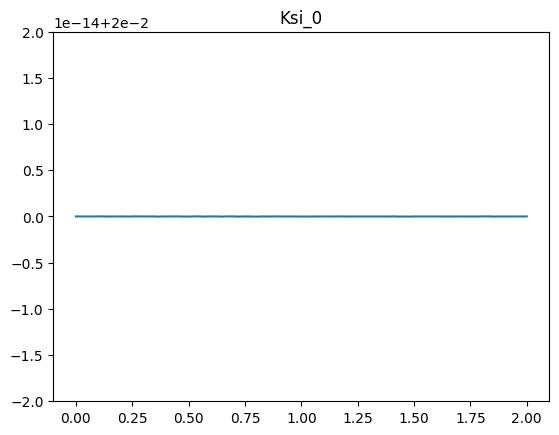

for strike K  0.9048374180359595 impl vol is  1.0919145204686835
for strike K  0.9253798099365876 impl vol is  1.1134541608266686
for strike K  0.9463885727637351 impl vol is  1.1343336034599154
for strike K  0.9678742944685111 impl vol is  1.1546240462036221
for strike K  0.9898478033787338 impl vol is  1.1743844779144286
for strike K  1.012320173656168 impl vol is  1.1936643829796254
for strike K  1.0353027308776581 impl vol is  1.2125049039492932
for strike K  1.0588070577429671 impl vol is  1.2309408148384615
for strike K  1.0828449999122005 impl vol is  1.2490014465481831
for strike K  1.1074286719757578 impl vol is  1.2667116542733416
for strike K  1.1325704635598166 impl vol is  1.2840925318521477
for strike K  1.1582830455704305 impl vol is  1.3011618937955085
for strike K  1.1845793765793844 impl vol is  1.3179351336481866
for strike K  1.2114727093550282 impl vol is  1.3344252261161742
for strike K  1.238976597541378 impl vol is  1.3506435660314242
for strike K  1.26710490248

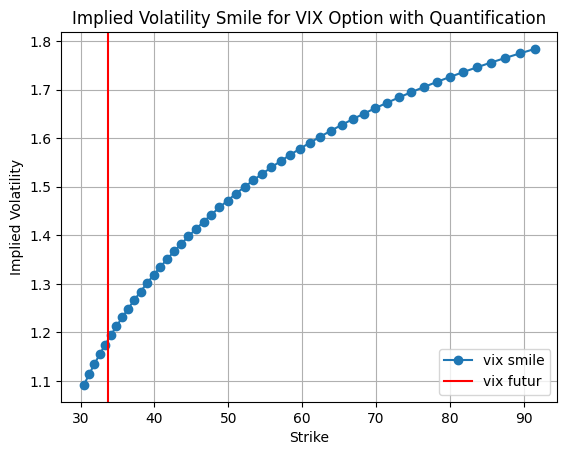

In [30]:
# ==== PARAMÈTRES ====
eps = 1 / 52
H = -0.1
a_k = [0.01, 0, 1, 0, 0.2, 0.05]
T = 1/12
n_steps = 400
N_sims = 40000
S0 = 100
rho = -0.65

# Courbe de variance à terme
T_nodes = np.array([0,0.03,1/12,2/12,3/12,6/12,12/12,24/12])
fv_nodes = np.ones_like(T_array_nodes)*np.sqrt(0.02)
fv_func = make_fv_curve_interpolator(T_array_nodes, fv_nodes)
def ksi_0(t):
    return fv_func(t)**2
X0 = np.linspace(0,2,100)
Y0 = [ksi_0(x) for x in X0]
plt.plot(X0,Y0)
plt.title("Ksi_0")
plt.show()
delta = 30/360


fv = interp1d(T_nodes, fv_nodes, kind='cubic', fill_value="extrapolate")

# === Instanciation de la classe ===
model = VIX_One_QUINTIC(eps=eps, H=H, n_steps=n_steps, delta=delta,a_k= a_k,T=T)

# === Calcul du vecteur beta ===

model.compute_beta_vector_full(ksi_0=fv)

# === Calcul de VIX_T (forward VIX) ===
vix_T = model.compute_vix_futures()

# === Strikes à tester ===
lm_vix = np.linspace(-0.1,1,50)
K_vec = np.exp(lm_vix)
# === Calcul des prix d'options sur VIX ===
# === Calcul des prix d'options sur VIX ===
# === Calcul des prix d'options sur VIX ===
C_vec = []
for K_i in K_vec:
    Ft, price, _ = model.vix_call_price(strike_perc_vix=K_i)
    C_vec.append((Ft, price))  # stocke les deux pour IV

# === Calcul des volatilités implicites ===
IV_vec = []
for K_i in K_vec:
    Ft, price, _ = model.vix_call_price(strike_perc_vix=K_i)
    try:
        Ft = float(np.squeeze(Ft))
        price = float(np.squeeze(price))
        iv = vec_find_vol_rat(price, Ft, Ft * K_i, T, r = 0,flag = 'c')
    except Exception as e:
        print(f"Failed to compute IV for strike={K_i}: {e}")
        iv = np.nan
    print("for strike K ", K_i, "impl vol is ", iv)
    IV_vec.append(iv)

IV_vec = np.array(IV_vec)

# === Affichage de la smile ===
plt.plot(K_vec * vix_T, IV_vec, marker='o',label="vix smile")  # x-axis = strike absolute
plt.axvline(x=vix_T,label="vix futur",color='r')
plt.legend()
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Smile for VIX Option with Quantification")
plt.grid(True)
plt.show()